# S11 dB

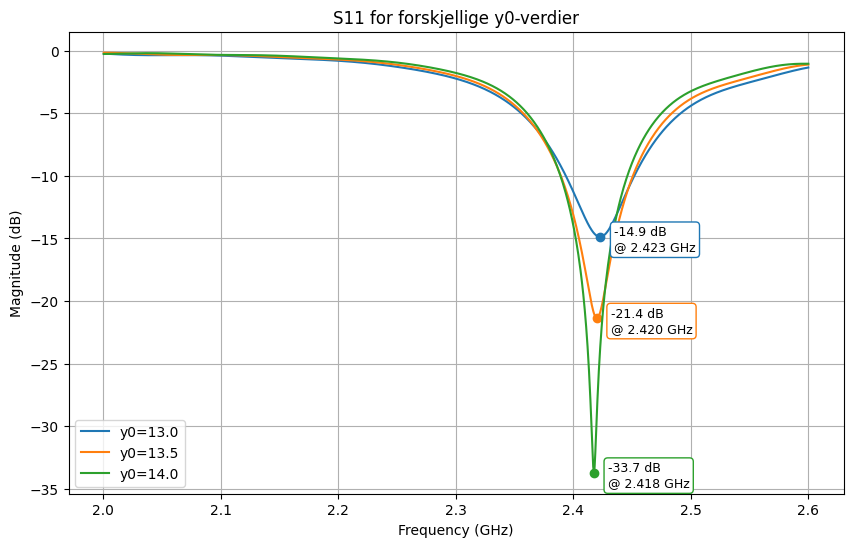

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths
file_path = 'CST_Data/S11_Sweep.txt'

# Define the line ranges for each y0 value
ranges = {
    'y0=13.0': (4, 1004),
    'y0=13.5': (1008, 2008),
    'y0=14.0': (2012, 3012)
}

# Initialize empty DataFrame to store all data
df = pd.DataFrame()

# Read the first file and extract data for each y0 value
for y0, (start, end) in ranges.items():
    data = pd.read_csv(file_path, skiprows=start, nrows=end-start, delimiter='\t', names=["Frequency / GHz", f"{y0}"])
    if df.empty:
        df = data
    else:
        df = pd.merge(df, data, on="Frequency / GHz")

# Plot the data from the first file
colors = { 'y0=13.0': 'tab:blue', 'y0=13.5': 'tab:orange', 'y0=14.0': 'tab:green' }
fig, ax = plt.subplots(figsize=(10, 6))

for column in df.columns[1:]:
    ax.plot(df["Frequency / GHz"], df[column], label=column, color=colors[column])
    
    # Find the minimum value
    min_value = df[column].min()
    min_index = df[column].idxmin()
    min_frequency = df["Frequency / GHz"][min_index]

    # Plot the minimum point
    ax.plot(min_frequency, min_value, 'o', color=colors[column])
    
    # Annotate with frequency and min value
    ax.annotate(
        f"{min_value:.1f} dB\n@ {min_frequency:.3f} GHz",
        (min_frequency, min_value),
        textcoords="offset points",
        xytext=(10, -10),
        ha='left',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[column], facecolor="white")
    )

# Plot formatting
ax.set_title('S11 for forskjellige y0-verdier')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Magnitude (dB)')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

# S11 Smith Chart

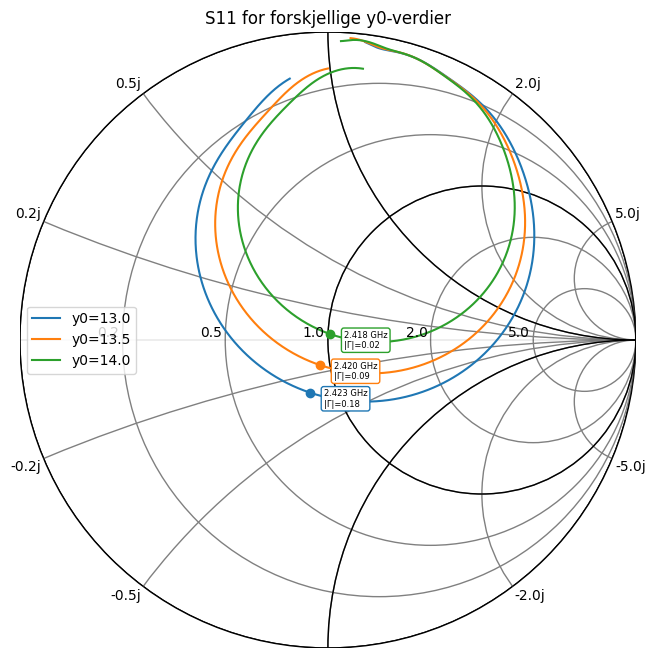

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import skrf as rf
import numpy as np

file_path = 'CST_Data/S11_Sweep_Smith.txt'

ranges = {
    'y0=13.0': (4, 1004),
    'y0=13.5': (1008, 2008),
    'y0=14.0': (2012, 3012)
}

# Dictionary to store Network objects
networks = {}

# Read the file and extract data for each y0 value
for y0, (start, end) in ranges.items():
    data = pd.read_csv(file_path, skiprows=start, nrows=end-start, delimiter='\t', 
                       names=["Frequency", "Mag", "Phase", "Ref Mag", "Ref Phase"])
    
    frequency = data["Frequency"].values * 1e9  # Convert GHz to Hz
    s11_mag = data["Mag"].values
    s11_phase = data["Phase"].values
    
    # Compute complex reflection coefficient (Gamma)
    s11_complex = s11_mag * np.exp(1j * np.deg2rad(s11_phase))
    
    # Store network
    networks[y0] = rf.Network(frequency=frequency, s=s11_complex)

# Define colors
colors = { 'y0=13.0': 'tab:blue', 'y0=13.5': 'tab:orange', 'y0=14.0': 'tab:green' }

# Create figure and plot Smith chart
fig, ax = plt.subplots(figsize=(8, 8))

rf.plotting.smith(ax=ax, draw_labels=True, ref_imm=1, chart_type='z')

for y0, network in networks.items():
    # Plot S11
    network.plot_s_smith(ax=ax, label=y0, color=colors[y0])
    
    # Find the point closest to the center (|Γ| closest to 0)
    distances = np.abs(network.s[:, 0, 0])
    min_index = np.argmin(distances)
    closest_point = network.s[min_index, 0, 0]
    closest_frequency = frequency[min_index] / 1e9  # Convert Hz to GHz
    
    # Plot the marker
    ax.plot(closest_point.real, closest_point.imag, 'o', color=colors[y0])
    
    # Annotate with frequency and |Γ|
    ax.annotate(
        f"{closest_frequency:.3f} GHz\n|Γ|={np.abs(closest_point):.2f}", 
        (closest_point.real, closest_point.imag),
        textcoords="offset points", xytext=(10,-10), ha='left', fontsize=6, 
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[y0], facecolor="white")
    )

# Add title and legend
ax.set_title('S11 for forskjellige y0-verdier')
ax.legend()

# Set axis limits and labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Add grid and ticks
ax.grid(True, which='both')
ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, 
               colors='black', grid_color='gray', grid_alpha=0.5)

# Show the plot
plt.show()


# Farfield Plots

## Importer data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Les inn dataen fra filen, hopp over de to første radene hvis nødvendig
file_path1 = 'CST_Data/2_0GHz3D.txt'
file_path2 = 'CST_Data/2_4GHz3D.txt'
file_path3 = 'CST_Data/2_6GHz3D.txt'

columns = ["Elev [deg]", "Azim [deg]", "Abs(Dir) [dBi]", "Abs(Azimu) [dBi]", "Phase(Azimu) [deg]", 
           "Abs(Eleva) [dBi]", "Phase(Eleva) [deg]", "Ax.Ratio [dB]"]

data2_0GHz = pd.read_csv(file_path1, skiprows=2, names=columns, sep=r"\s+")
data2_4GHz = pd.read_csv(file_path2, skiprows=2, names=columns, sep=r"\s+")
data2_6GHz = pd.read_csv(file_path3, skiprows=2, names=columns, sep=r"\s+")

## Azimuth = 0

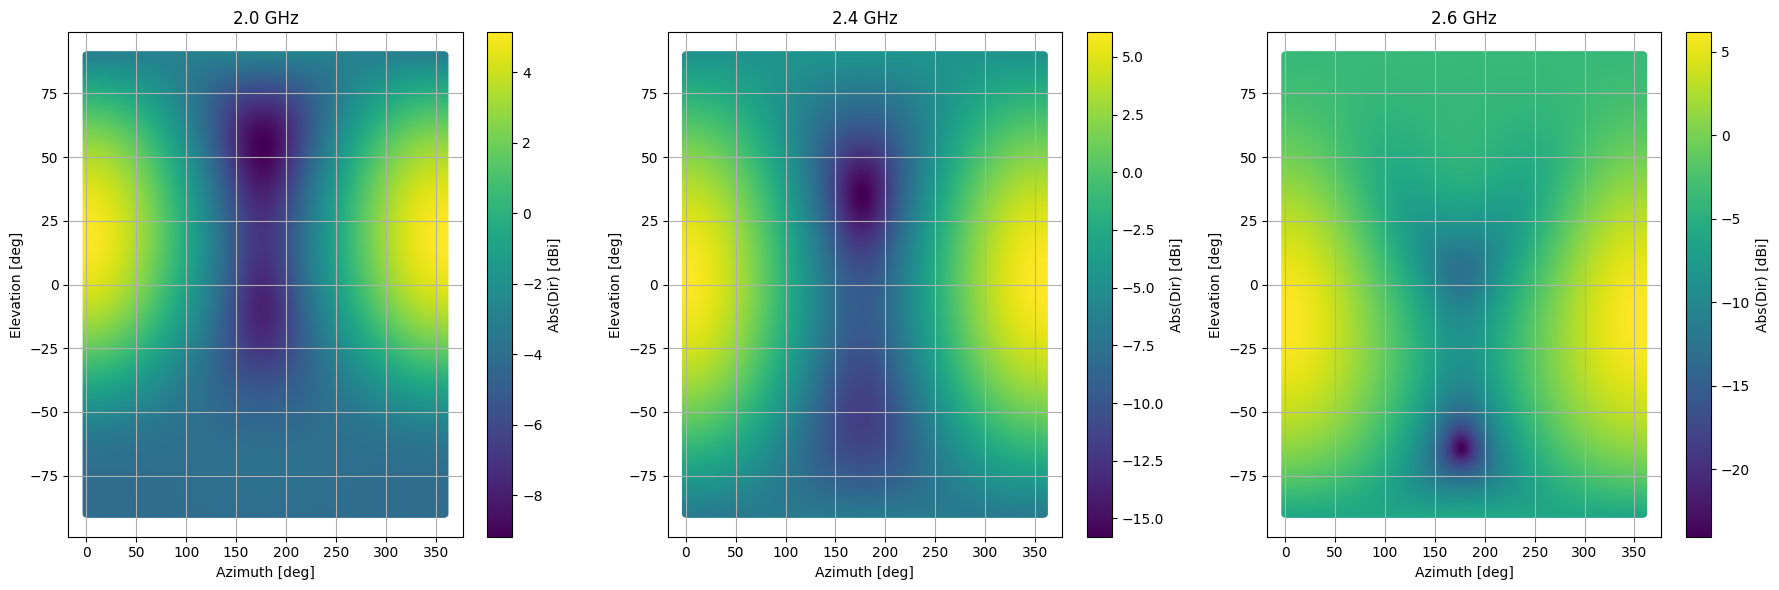

In [82]:
# Plot the 2D radiation pattern for each frequency
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# 2.0 GHz
data2_0GHz.plot.scatter(x="Azim [deg]", y="Elev [deg]", c="Abs(Dir) [dBi]", cmap="viridis", ax=ax[0])
ax[0].set_title("2.0 GHz")
ax[0].set_xlabel("Azimuth [deg]")
ax[0].set_ylabel("Elevation [deg]")
ax[0].grid(True)

# 2.4 GHz
data2_4GHz.plot.scatter(x="Azim [deg]", y="Elev [deg]", c="Abs(Dir) [dBi]", cmap="viridis", ax=ax[1])
ax[1].set_title("2.4 GHz")
ax[1].set_xlabel("Azimuth [deg]")
ax[1].set_ylabel("Elevation [deg]")
ax[1].grid(True)

# 2.6 GHz
data2_6GHz.plot.scatter(x="Azim [deg]", y="Elev [deg]", c="Abs(Dir) [dBi]", cmap="viridis", ax=ax[2])
ax[2].set_title("2.6 GHz")
ax[2].set_xlabel("Azimuth [deg]")
ax[2].set_ylabel("Elevation [deg]")
ax[2].grid(True)

plt.tight_layout()
plt.show()


## Azimuth = 90